In [1]:
pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=150ded51d92a815e1f4c908162777cfa52423794c592600873d9f5021f17ca11
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [3]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.shape

(284807, 31)

In [7]:
print('Distribution of classes :\n',df.Class.value_counts())
print('\npercentage of Fraudulent classes (1) is',(len(df[df.Class == 1])/len(df))*100,'%')
print('percentage of Non - Fraudulent classes (0) is',(len(df[df.Class == 0])/len(df))*100,'%')

Distribution of classes :
 0    284315
1       492
Name: Class, dtype: int64

percentage of Fraudulent classes (1) is 0.1727485630620034 %
percentage of Non - Fraudulent classes (0) is 99.82725143693798 %


Next, split the dataset into a training (70%) and testing set (30%). Set the random state to 0.**[0.2]**

Make sure to separate out the column corresponding to the targets.

In [8]:
columns = df.columns.drop(['Class','Time','Amount'])
X_train, X_test, y_train, y_test = train_test_split(df[columns],df['Class'],test_size=0.3,random_state=0)

In [9]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
161145,-0.132066,0.107044,-0.650588,-0.996032,1.814333,1.740740,0.496852,0.633016,0.017181,-0.362707,0.527911,0.505396,-0.742107,0.492430,-0.163585,-0.950404,0.262987,-1.760767,-0.939037,-0.062612,-0.062489,0.005292,0.251519,-2.466810,-0.889690,0.337462,0.306395,0.074817
204520,2.125994,0.014207,-1.514760,0.115021,0.598510,-0.333235,0.199289,-0.264353,0.384111,0.028747,-1.208334,0.838156,1.511476,-0.042076,-0.002894,0.080270,-0.658905,-0.747678,0.431762,-0.086076,-0.329368,-0.788150,0.267730,0.066122,-0.135785,0.203841,-0.068267,-0.057678
182659,-0.086694,0.166240,1.573127,0.687266,0.222359,1.102606,1.575093,-1.098608,0.763887,1.404677,1.346697,0.140822,0.159637,-1.147153,0.664997,-0.133032,-1.267675,0.818995,0.405276,0.052960,0.015324,1.063663,-0.410841,0.722723,-0.171733,-0.613543,-1.201571,-1.139931
25117,1.352339,-0.534984,0.555143,-0.629355,-1.144170,-0.852967,-0.642128,-0.032659,-0.654482,0.619206,0.103615,-1.067971,-1.227629,0.197196,1.151364,0.846905,0.710309,-1.963506,0.130406,-0.066712,-0.014814,-0.180379,0.178112,0.347720,0.151810,-0.404361,0.013746,0.016152
227642,-1.526760,0.647782,0.615391,-0.561114,0.836950,-0.514251,0.984325,-0.097430,-0.062634,-1.033567,-0.706095,-0.612354,-0.336939,-1.384147,0.314279,0.552201,0.512582,0.370183,-0.163736,-0.073333,-0.221533,-0.393158,-0.214990,0.588447,0.679496,0.518434,0.065022,0.147294


Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

In [10]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

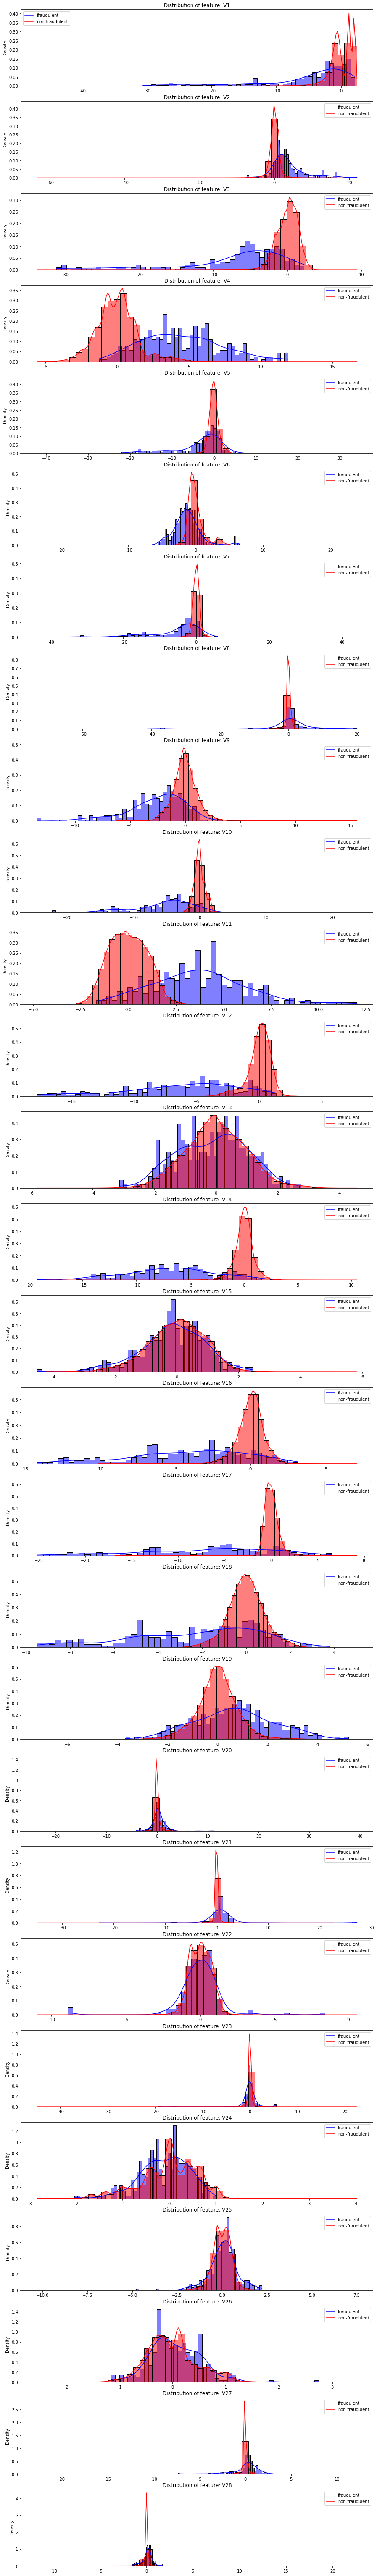

In [11]:
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

**Gaussian mixture models are good in learning the representations of a multimodal data distrubution. These graphs would help us in selecting the best features, because the features which has different distributions for fraudulent and non-fraudulent classes helps the gaussian model to distinguish between two classes. These features would help the model to differentiate outliers/anomalies, as any new datapoint which has very less probability of being in non-fraudulent distrubution can be labeled as an outlier or anomaly.**

In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
gmm_1 = GaussianMixture(n_components=1)
scores = []
for i in columns:
  gmm_1.fit(X_train[i].values.reshape(-1,1))
  y = gmm_1.score_samples(X_train[i].values.reshape(-1,1))
  scores.append(roc_auc_score(y_train,-y))
feature_rank = pd.DataFrame(data = scores,index=columns,columns=['Scores'])
feature_rank.T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
Scores,0.705102,0.837499,0.876537,0.892103,0.771825,0.73438,0.862967,0.773238,0.802874,0.9136,0.897175,0.92018,0.572152,0.952459,0.514764,0.902137,0.934852,0.80803,0.741874,0.734692,0.833521,0.561287,0.696326,0.469229,0.574918,0.503272,0.835479,0.814201


In [13]:
print('The best feature according to AUC is {} with AUC score {}'.format(columns[scores.index(max(scores))],max(scores))) 

The best feature according to AUC is V14 with AUC score 0.9524586211308497


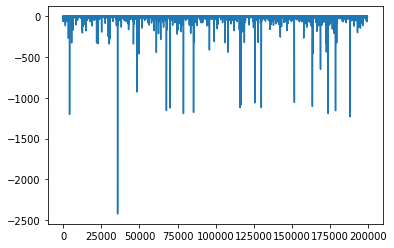

In [14]:
plt.plot(y) #ploting log probabilities to get the idea of range of threshold values.

In [15]:
from sklearn.metrics import f1_score
gmm_1 = GaussianMixture(n_components=1)
gmm_1.fit(X_train['V14'].values.reshape(-1,1))
f1 = []
t = -np.arange(0,50,0.5)
for i in t:
  y = gmm_1.score_samples(X_train['V14'].values.reshape(-1,1))
  y_new = np.zeros(y.shape)
  y_new[y<i] = 1
  y_new[y>=i] = 0
  f1.append(f1_score(y_train,y_new))

In [16]:
print('The best Threshold is {} with F1 Score of {}'.format(t[f1.index(max(f1))],max(f1)))

The best Threshold is -20.5 with F1 Score of 0.6137404580152672


Gaussian Model with only non-fraudulent class observations
for question 6

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
gmm_1 = GaussianMixture(n_components=1)
scores = []
for i in columns:
  gmm_1.fit(X_train[i][y_train==0].values.reshape(-1,1))
  y = gmm_1.score_samples(X_train[i].values.reshape(-1,1))
  scores.append(roc_auc_score(y_train,-y))
pd.DataFrame(data = scores,index=columns).T

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0.70535,0.838015,0.877392,0.892612,0.771881,0.734514,0.863167,0.773353,0.803263,0.913558,0.897612,0.920788,0.572142,0.952599,0.514781,0.902069,0.93444,0.80798,0.741989,0.734835,0.833878,0.561289,0.696345,0.469245,0.574931,0.503278,0.835538,0.814264


In [18]:
print('The best feature according to AUC is {} with AUC score {}'.format(columns[scores.index(max(scores))],max(scores))) 

The best feature according to AUC is V14 with AUC score 0.9525990781886603


In [19]:
from sklearn.metrics import f1_score
gmm_1 = GaussianMixture(n_components=1)
gmm_1.fit(X_train['V14'][y_train==0].values.reshape(-1,1))
f1 = []
t = -np.arange(0,50,0.5)
for i in t:
  y = gmm_1.score_samples(X_train['V14'].values.reshape(-1,1))
  y_new = np.ones(y.shape)
  y_new[y<i] = 1
  y_new[y>=i] = 0
  f1.append(f1_score(y_train,y_new))

In [20]:
print('The best Threshold is {} with F1 Score of {}'.format(t[f1.index(max(f1))],max(f1)))

The best Threshold is -23.0 with F1 Score of 0.6128048780487805


As we can observe there is no significant difference in performance of the model.

## **Multiple feature model with one Gaussian distribution**




In [21]:
def plot_features(feature1,feature2):
    print('Plotting feature ',feature1, 'and feature ',feature2)
    sns.scatterplot(x = X_train[feature1],y = X_train[feature2],hue=y_train,palette=['blue','red'],alpha=0.6)
    plt.show()

def fit(n,feature1,feature2):
  gmm = GaussianMixture(n_components=n)
  gmm.fit(X_train[[feature1,feature2]])
  p = gmm.score_samples(X_train[[feature1,feature2]])
  print('AUC Score: ',roc_auc_score(y_train,-p))
  

def threshold(n,feature1,feature2):
  gmm = GaussianMixture(n_components=n)
  gmm.fit(X_train[[feature1,feature2]])
  p = gmm.score_samples(X_train[[feature1,feature2]])
  f1 = []
  t = -np.arange(0,50,0.5)
  for i in t:
    y_new = np.zeros(p.shape)
    y_new[p<i] = 1
    y_new[p>=i] = 0
    f1.append(f1_score(y_train,y_new))
  print('The best F1 score is {} with threshold of {}'.format(max(f1),t[f1.index(max(f1))]))

Plotting feature  V14 and feature  V24


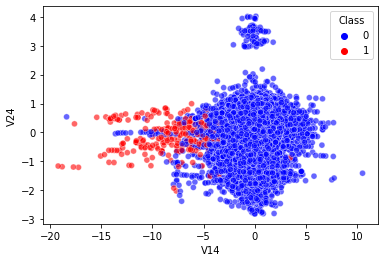

In [22]:
plot_features('V14','V24')

As we could see there are two clusters of non-fraudulent datapoints, we will use 2 gaussian components to fit the data.

In [23]:
print('AUC score with 2 component')
fit(2,'V24','V14')

AUC score with 2 component
AUC Score:  0.9433746584970294


Plotting feature  V14 and feature  V17


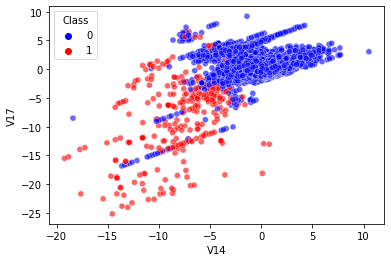

In [24]:
plot_features('V14','V17')

Since there is only on cluster of non-fraudulent datapoints, we will choose 1 component.

In [25]:
fit(1,'V14','V17')

AUC Score:  0.9614769283917324


Plotting feature  V9 and feature  V15


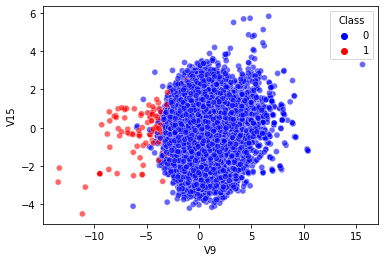

In [26]:
plot_features('V9','V15')

Since there is only one cluster of non-fraudulent datapoints, we will choose 1 component.

In [27]:
fit(1,'V9','V15')

AUC Score:  0.7882403333277261


Plotting feature  V10 and feature  V11


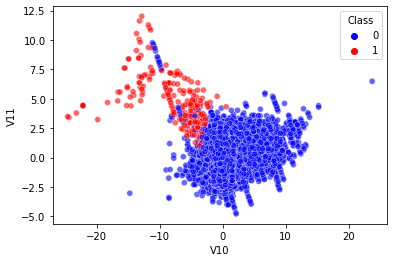

In [28]:
plot_features('V10','V11')

Since there is only one cluster of non-fraudulent datapoints, we will choose 1 component.

In [29]:
fit(1,'V10','V11')

AUC Score:  0.9238031530162694


As V14 and V17 gave us the best AUC. We will find the F1 score using these features

In [30]:
threshold(1,'V14','V17')

The best F1 score is 0.6970128022759603 with threshold of -30.5


##Plotting outliers

Plotting feature  V4 and feature  V5


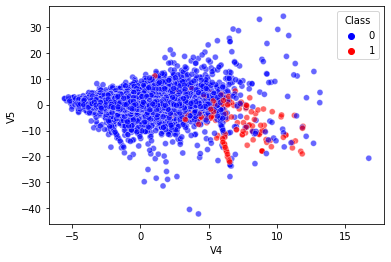

In [31]:
plot_features('V4','V5')

<Figure size 720x720 with 0 Axes>

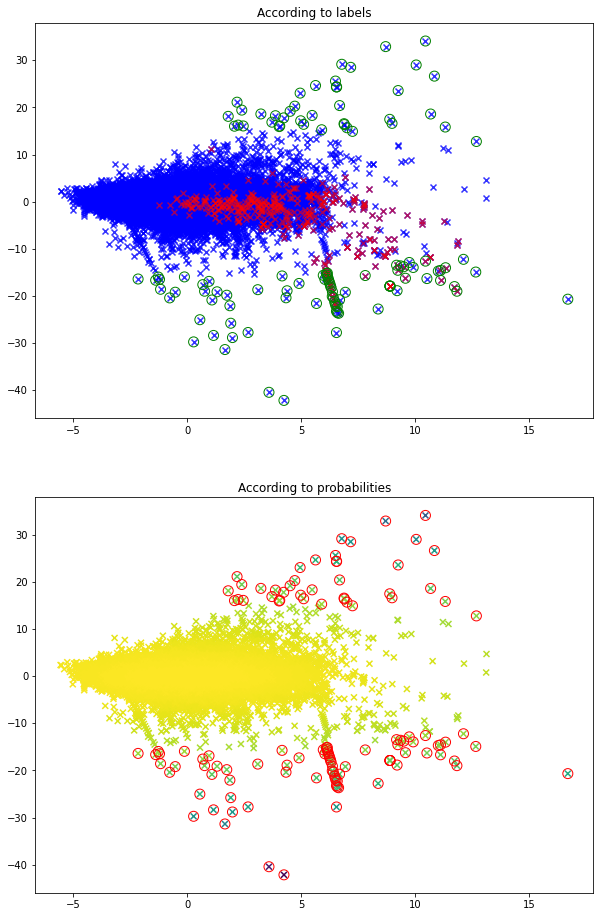

In [32]:
plt.figure(figsize=(10,10))
gmm = GaussianMixture(n_components=1)
gmm.fit(X_train[['V4','V5']])
c = gmm.score_samples(X_train[['V4','V5']])
threshold= -70 #This threshold was decided by trail and error method by visualizing the outliers in the plot.
outliers = np.nonzero(c<threshold)[0]

plt.figure(figsize=(10,8*2))
gs = gridspec.GridSpec(2,1)
#for plotting fraudent and non fraudulent classes in blue and red colors
ax = plt.subplot(gs[0])
ax.scatter(X_train['V4'],X_train['V5'],c='b',cmap='viridis',marker='x',alpha=0.8)
ax.scatter(X_train['V4'][y_train==1],X_train['V5'][y_train==1],cmap= 'viridis',marker='x',c='r',alpha=0.6)
ax.scatter(X_train['V4'].iloc[outliers],X_train['V5'].iloc[outliers],marker="o",facecolor= "none",edgecolor="g",s=100)
ax.set_title('According to labels')
#for plotting according to probabilities
ax = plt.subplot(gs[1])
ax.scatter(X_train['V4'],X_train['V5'],c=c,cmap='viridis',marker='x')
ax.scatter(X_train['V4'].iloc[outliers],X_train['V5'].iloc[outliers],marker="o",facecolor= "none",edgecolor="r",s=100)
ax.set_title('According to probabilities')
plt.show()

## **Single feature model with two Gaussian distributions.**

In [33]:
def compute_c(S1,S2):
    b_f1 = 0
    f1_n = 0
    b_c = 0
    for c in np.arange(0,10,0.1):
      y_pred = (S1 < c*S2)
      #y_pred = np.where(S1 < c*S2,1,0)
      f1_n = f1_score(y_train,y_pred)
      if f1_n > b_f1:
        b_f1 = f1_n
        b_c = c
    return b_f1,b_c

In [34]:
best_f1 = []
best_c = []
for i in columns:

  G1 = GaussianMixture(n_components=1).fit(X_train[i][y_train==0].values.reshape(-1,1))
  G2 = GaussianMixture(n_components=1).fit(X_train[i][y_train==1].values.reshape(-1,1))

  S1 = np.array(G1.score_samples(X_train[i].values.reshape(-1,1)))
  S2 = np.array(G2.score_samples(X_train[i].values.reshape(-1,1)))

  #y_pred = np.zeros(S1.shape)
  b_f1,b_c = compute_c(S1,S2)
  print('Best F1 score for feature',i,'is',b_f1,' with C: ', b_c)

  best_f1.append(b_f1)
  best_c.append(b_c)

Best F1 score for feature V1 is 0.1544943820224719  with C:  6.7
Best F1 score for feature V2 is 0.1764705882352941  with C:  6.1000000000000005
Best F1 score for feature V3 is 0.29085872576177285  with C:  5.0
Best F1 score for feature V4 is 0.3624338624338624  with C:  4.2
Best F1 score for feature V5 is 0.18978102189781024  with C:  8.8
Best F1 score for feature V6 is 0.10267229254571027  with C:  1.8
Best F1 score for feature V7 is 0.24808575803981625  with C:  9.8
Best F1 score for feature V8 is 0.09025641025641025  with C:  7.6000000000000005
Best F1 score for feature V9 is 0.43359375000000006  with C:  3.1
Best F1 score for feature V10 is 0.4274193548387097  with C:  8.1
Best F1 score for feature V11 is 0.603588907014682  with C:  3.8000000000000003
Best F1 score for feature V12 is 0.6866666666666666  with C:  5.0
Best F1 score for feature V13 is 0.005001339644547647  with C:  1.1
Best F1 score for feature V14 is 0.6353677621283255  with C:  9.700000000000001
Best F1 score for f

In [35]:
print('Best feature is ',columns[best_f1.index(max(best_f1))],'with f1 score',max(best_f1),' with C ',best_c[best_f1.index(max(best_f1))])

Best feature is  V12 with f1 score 0.6866666666666666  with C  5.0


## **Multivariate and Mixture of Gaussians Distribution**

**The Two gaussian model with 7 features ['V14','V17','V12','V10','V16','V11','V4'] with n_components = 1 for gaussian distribution fitted on non-fraudulent data and n_components = 6 for gaussian distribution fitted on fraudulent data with threshold C = 5.8 works best.**

In [36]:
model = dict() #to store all the models with their f1 scores
print('Important features based on AUC scores')
feature_rank.sort_values(['Scores'],ascending=0).head(10)

Important features based on AUC scores


,Scores
V14,0.952459
V17,0.934852
V12,0.920180
V10,0.913600
V16,0.902137
V11,0.897175
V4,0.892103
V3,0.876537
V7,0.862967
V2,0.837499


From the above table, we choose ['V14','V17','V12','V10','V16','V11','V4'] as the best features.

In [37]:
cols = ['V14','V17','V12','V10','V16','V11','V4']
cols1 = ['V12']
cols2 = ['V14','V17']
cols3 = ['V14','V17','V12']

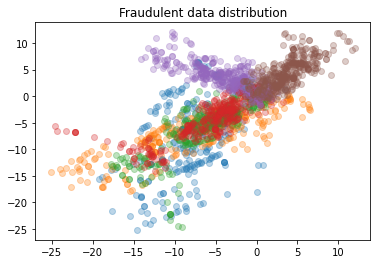

In [38]:
for i in range(len(cols)-1):
  
  plt.scatter(X_train[cols[i]][y_train==1],X_train[cols[i+1]][y_train==1],alpha=0.3)
  plt.title('Fraudulent data distribution')

As we can see, there are multiple clusters in the distribution of fraudulent data. whereas in the distribution of non-fraudulent data, the datapoints are more closly packed.

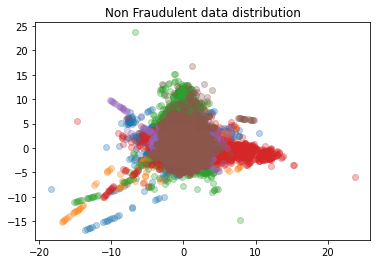

In [39]:
for i in range(len(cols)-1):
  
  plt.scatter(X_train[cols[i]][y_train==0],X_train[cols[i+1]][y_train==0],alpha=0.3)
  plt.title('Non Fraudulent data distribution')

To check for overfitting, we are further dividing the training dataset into training and validation datasets.

In [40]:
xtrain,xvalid,ytrain,yvalid = train_test_split(X_train,y_train,test_size=0.3,random_state = 0)

In [41]:
columns = xtrain.columns

In [42]:
xtrain.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
15307,-0.831432,1.541154,1.367789,1.272423,0.698616,-0.419087,1.282873,-0.118477,-1.754709,0.397037,0.970365,0.194262,-0.364506,0.493539,-1.023416,0.689363,-0.955890,0.068970,-1.114561,-0.203008,0.097985,0.025185,-0.374804,0.309520,0.751803,-0.049826,-0.361196,-0.052397
182749,2.018978,-0.981888,-1.607440,-0.570586,0.371100,1.483999,-0.803163,0.475355,-0.034754,0.738953,0.393277,0.168230,-1.464750,0.522669,-0.328287,-2.795075,0.756941,0.405502,-1.276602,-0.828387,-0.117819,0.454730,0.123886,-0.758215,0.040156,0.021710,0.053237,-0.079384
28248,1.339110,-0.795560,0.851154,-0.809708,-1.364949,-0.228602,-1.175228,0.144604,-0.522823,0.795770,0.954725,-0.451903,-0.456419,-0.122116,0.521113,1.808607,-0.273180,-0.156588,0.640637,0.081214,0.407480,1.042789,-0.153842,0.033610,0.413555,-0.044836,0.026879,0.012179
75663,1.269081,0.062241,-0.078896,0.142954,0.362636,0.563231,-0.196364,0.207967,-0.016426,0.082029,0.365484,0.312344,-0.269678,0.525689,0.761587,0.637003,-0.848599,0.035882,0.329456,-0.115532,-0.275656,-0.826880,-0.006062,-1.366849,0.271593,0.193537,-0.022906,-0.009869
40896,-0.809854,-1.412375,-0.271392,-3.201806,-0.824211,-1.596964,0.995237,-1.115408,1.429778,-2.205711,1.324638,0.714572,-2.095702,1.185149,0.171246,-0.240869,-0.659244,0.459270,-0.613752,0.372492,1.097384,-0.398596,-0.655660,0.530796,1.000030,-1.083606,0.056355,0.280893


In [43]:
print(X_train.shape)
print(xtrain.shape)

(199364, 28)
(139554, 28)


In [44]:
from sklearn.metrics import roc_curve

def fit_gaussian(Components,Features,t0,t1,s,model_name,train=xtrain):          #Function to experiment different gaussian models.

  """ Components : Number of components to be tested
      Features : Features to be used in training
      to, t1 : Range for finding threshold
      s : specifying the incrementation of values for finding threshold
      model_name: Type of model being tested
      train : Training data
  """
  max_f1 = []
  f1_v = []
  ct = []
  for n in range(1,Components):
    print('\n\nFor number of components = ',n)
    gmm = GaussianMixture(n,random_state=31) 
    gmm.fit(train[Features])
    p = gmm.score_samples(xtrain[Features])
    fpr,tpr,t = roc_curve(ytrain,-p)
    plt.plot(fpr,tpr)
    plt.title('ROC Curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    print('AUC :',roc_auc_score(ytrain,-p))

    
    f1 = []
    t = -np.arange(t0,t1,s)
    for i in t:
      y_t = np.zeros(p.shape)
      y_t = np.where(p<i,1,0)
      f1.append(f1_score(ytrain,y_t))
    print('The best training F1 Score is {} with threshold {}'.format(max(f1),t[f1.index(max(f1))]))
    max_f1.append(max(f1))
    ct.append(t[f1.index(max(f1))])
    #validation
    thres = t[f1.index(max(f1))]
    p = gmm.score_samples(xvalid[Features])
    y_v = np.zeros(p.shape)
    y_v = np.where(p<thres,1,0)
    f1_v.append(f1_score(yvalid,y_v))
    print('validation F1 Score is ',f1_v[-1],' with threshold ',thres,'\n')
    
  print('\nBest Validation F1 Score is {} with n_components {}'.format(max(f1_v),f1_v.index(max(f1_v))+1))


  model[model_name] = [f1_v.index(max(f1_v))+1,ct[f1_v.index(max(f1_v))],max_f1[f1_v.index(max(f1_v))],max(f1_v)]

## Single gaussian model with all features

Threshold values range had been choosen according to each model by trail and error. As model with all features needed a threshold value greater than 300 and all the other models with selected features needed threshold range of 1 to 120, we have intialized each model with its own threshold range to save time in running the program.



For number of components =  1


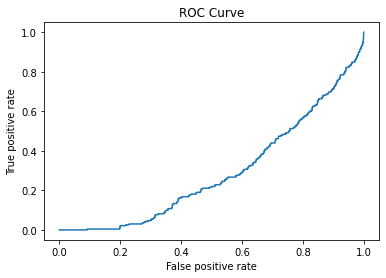

AUC : 0.2906210136379679
The best training F1 Score is 0.0033193595925199945 with threshold -1
validation F1 Score is  0.0037715067670176733  with threshold  -1 



For number of components =  2


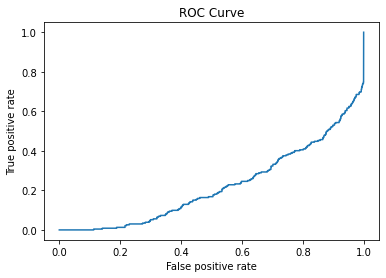

AUC : 0.22100162164650583
The best training F1 Score is 0.0025763788994568135 with threshold -1
validation F1 Score is  0.003205074701610884  with threshold  -1 



For number of components =  3


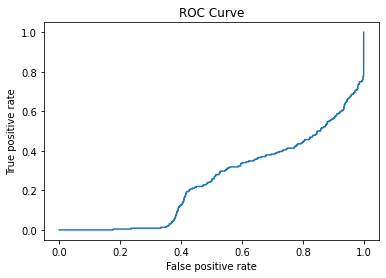

AUC : 0.24809449729205824
The best training F1 Score is 0.0026051544842295112 with threshold -13
validation F1 Score is  0.0033050677705815587  with threshold  -13 



For number of components =  4


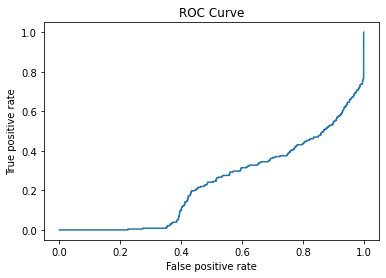

AUC : 0.23561676646854793
The best training F1 Score is 0.0025623224088693573 with threshold -14
validation F1 Score is  0.0032717378603502093  with threshold  -14 



For number of components =  5


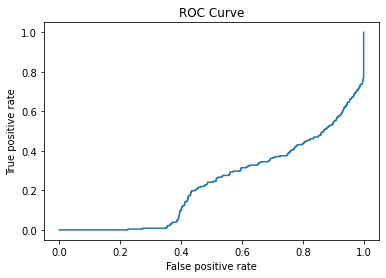

AUC : 0.23561020761134338
The best training F1 Score is 0.002562304069625961 with threshold -11
validation F1 Score is  0.0034383762852183202  with threshold  -11 


Best Validation F1 Score is 0.0037715067670176733 with n_components 1


In [45]:
fit_gaussian(6,columns,1,100,1,'Single Gaussian model fitted on only fraudulent class with all features',train=xtrain[ytrain==1])



For number of components =  1


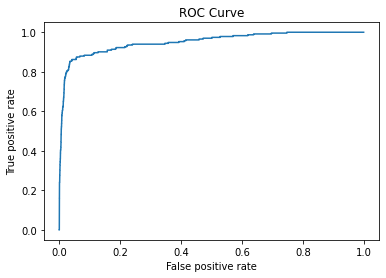

AUC : 0.9511754957134775
The best training F1 Score is 0.25 with threshold -390
validation F1 Score is  0.25108225108225113  with threshold  -390 



For number of components =  2


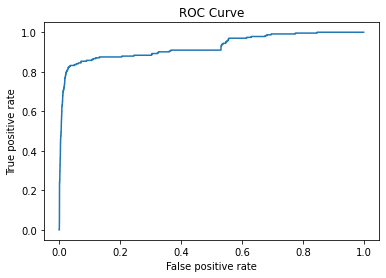

AUC : 0.9264751797993138
The best training F1 Score is 0.2798982188295165 with threshold -380
validation F1 Score is  0.2681564245810056  with threshold  -380 



For number of components =  3


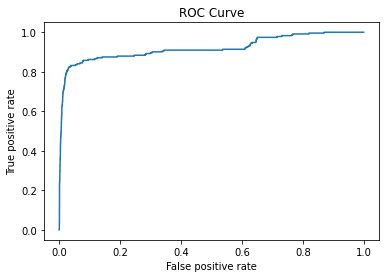

AUC : 0.9201508636158657
The best training F1 Score is 0.27848101265822783 with threshold -365
validation F1 Score is  0.2681564245810056  with threshold  -365 



For number of components =  4


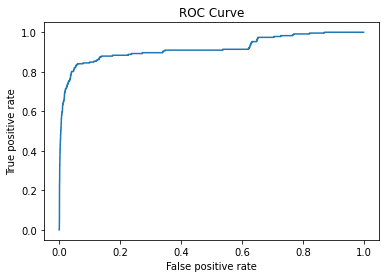

AUC : 0.9182798567842593
The best training F1 Score is 0.29084380610412924 with threshold -90
validation F1 Score is  0.2868217054263566  with threshold  -90 



For number of components =  5


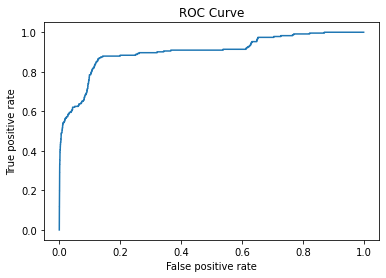

AUC : 0.9017473599980992
The best training F1 Score is 0.30522088353413657 with threshold -95
validation F1 Score is  0.2943722943722944  with threshold  -95 



For number of components =  6


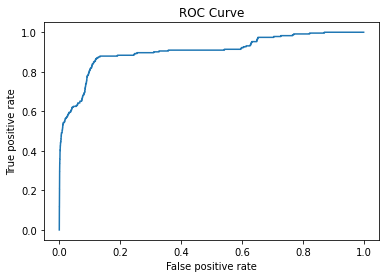

AUC : 0.9041728068295276
The best training F1 Score is 0.3070539419087137 with threshold -95
validation F1 Score is  0.3008849557522124  with threshold  -95 



For number of components =  7


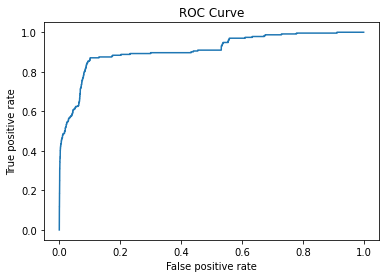

AUC : 0.9102917565312605
The best training F1 Score is 0.2674897119341564 with threshold -85
validation F1 Score is  0.2545454545454546  with threshold  -85 


Best Validation F1 Score is 0.3008849557522124 with n_components 6


In [46]:
fit_gaussian(8,columns,50,400,5,'Single Gaussian model fitted on whole training data with all features')



For number of components =  1


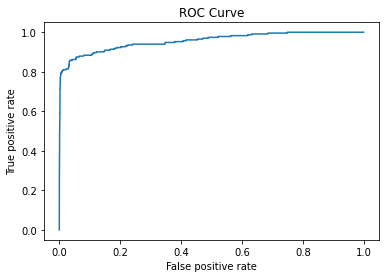

AUC : 0.9561018781101976
The best training F1 Score is 0.4641350210970464 with threshold -305
validation F1 Score is  0.5014925373134329  with threshold  -305 



For number of components =  2


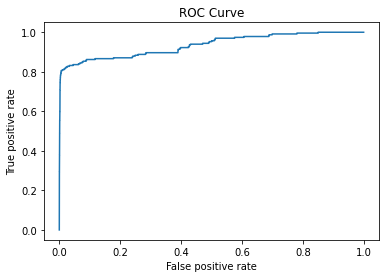

AUC : 0.9347118978659706
The best training F1 Score is 0.46402877697841727 with threshold -200
validation F1 Score is  0.5247148288973384  with threshold  -200 



For number of components =  3


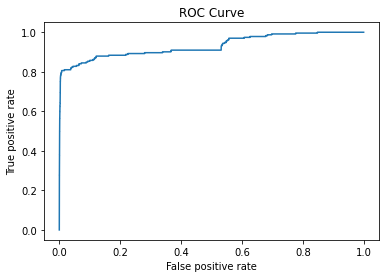

AUC : 0.9310751352980864
The best training F1 Score is 0.46816479400749067 with threshold -105
validation F1 Score is  0.5528455284552846  with threshold  -105 



For number of components =  4


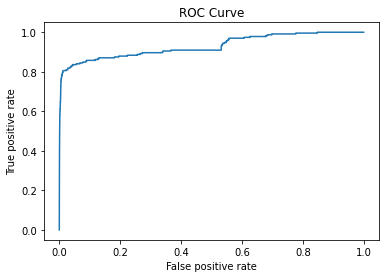

AUC : 0.9299213951902044
The best training F1 Score is 0.45833333333333337 with threshold -80
validation F1 Score is  0.5447154471544715  with threshold  -80 



For number of components =  5


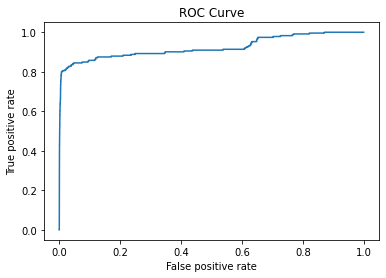

AUC : 0.9233511218615869
The best training F1 Score is 0.4773869346733668 with threshold -160
validation F1 Score is  0.5136612021857924  with threshold  -160 


Best Validation F1 Score is 0.5528455284552846 with n_components 3


In [47]:
fit_gaussian(6,columns,50,400,5,'Single Gaussian model fitted on only non-fraudulent class with all features',train=xtrain[ytrain==0])

##Single gaussian models with selected features



For number of components =  1


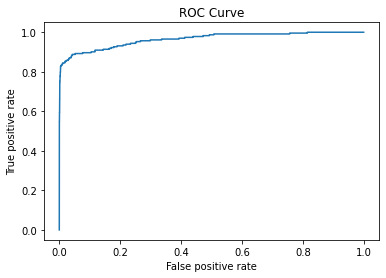

AUC : 0.9648663676157787
The best training F1 Score is 0.6365914786967418 with threshold -98
validation F1 Score is  0.7157894736842105  with threshold  -98 



For number of components =  2


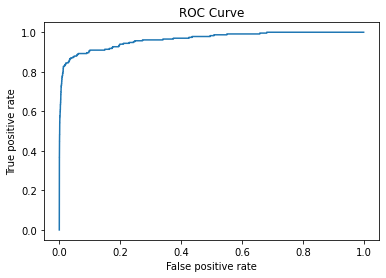

AUC : 0.9641657764771165
The best training F1 Score is 0.48484848484848475 with threshold -27
validation F1 Score is  0.577319587628866  with threshold  -27 



For number of components =  3


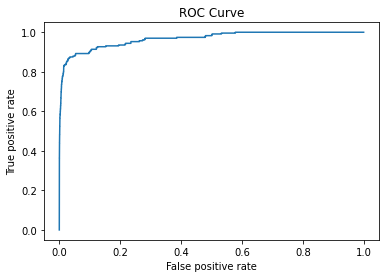

AUC : 0.9669412249668221
The best training F1 Score is 0.4723618090452261 with threshold -27
validation F1 Score is  0.5789473684210525  with threshold  -27 



For number of components =  4


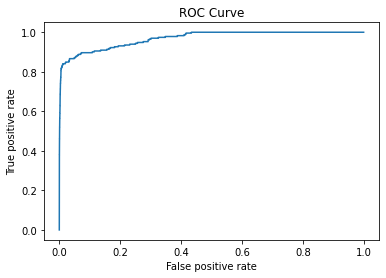

AUC : 0.9687153339646337
The best training F1 Score is 0.4922279792746115 with threshold -32
validation F1 Score is  0.5957446808510639  with threshold  -32 



For number of components =  5


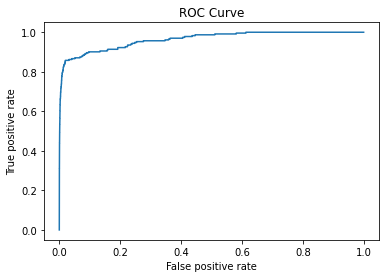

AUC : 0.9635611859700847
The best training F1 Score is 0.46698113207547165 with threshold -26
validation F1 Score is  0.5125628140703518  with threshold  -26 


Best Validation F1 Score is 0.7157894736842105 with n_components 1


In [48]:
# cols include ['V14','V17','V12','V10','V16','V11','V4'] features
fit_gaussian(6,cols,1,100,1,'Single Gaussian model fitted on whole training data with selected features [cols]',train=xtrain)



For number of components =  1


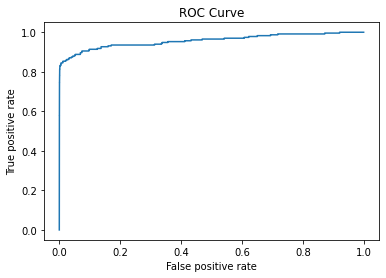

AUC : 0.9573487416151818
The best training F1 Score is 0.6933867735470942 with threshold -33
validation F1 Score is  0.7265306122448979  with threshold  -33 



For number of components =  2


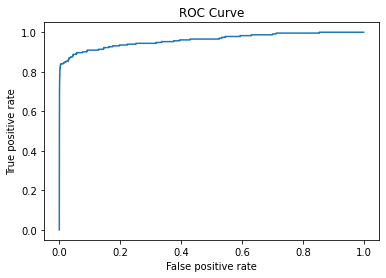

AUC : 0.9603909994658862
The best training F1 Score is 0.6566523605150214 with threshold -15
validation F1 Score is  0.7033898305084746  with threshold  -15 



For number of components =  3


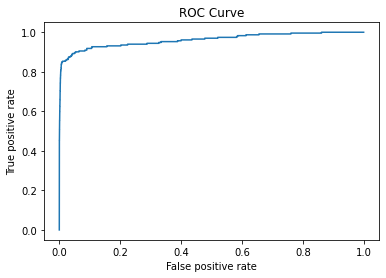

AUC : 0.9611499087452584
The best training F1 Score is 0.5441176470588235 with threshold -15
validation F1 Score is  0.5714285714285714  with threshold  -15 



For number of components =  4


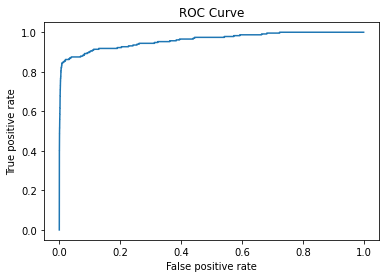

AUC : 0.9602046907956711
The best training F1 Score is 0.511166253101737 with threshold -14
validation F1 Score is  0.5482233502538072  with threshold  -14 



For number of components =  5


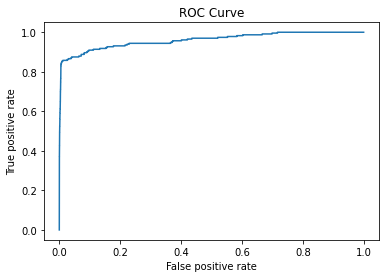

AUC : 0.9601742168600746
The best training F1 Score is 0.4568245125348189 with threshold -14
validation F1 Score is  0.47674418604651164  with threshold  -14 


Best Validation F1 Score is 0.7265306122448979 with n_components 1


In [49]:
# cols3 include ['V14','V12','V17'] features
fit_gaussian(6,cols3,1,100,1,'Single Gaussian model fitted on whole training data with selected features[cols3]',train=xtrain)



For number of components =  1


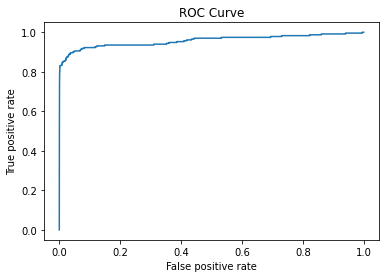

AUC : 0.9574946452499766
The best training F1 Score is 0.6809421841541755 with threshold -31
validation F1 Score is  0.7327586206896551  with threshold  -31 



For number of components =  2


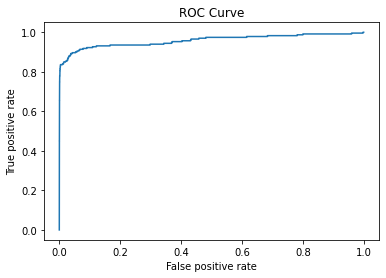

AUC : 0.9581132197355766
The best training F1 Score is 0.6284501061571126 with threshold -10
validation F1 Score is  0.6808510638297871  with threshold  -10 



For number of components =  3


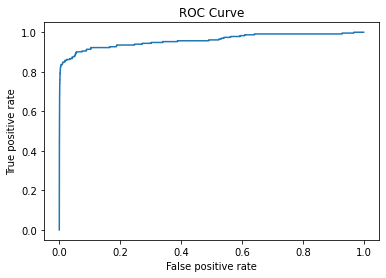

AUC : 0.9586011739611884
The best training F1 Score is 0.5707964601769911 with threshold -10
validation F1 Score is  0.6608695652173914  with threshold  -10 



For number of components =  4


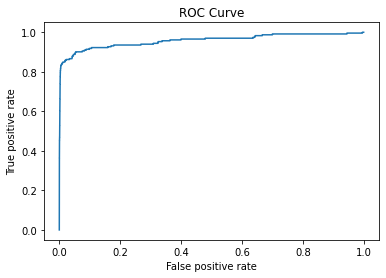

AUC : 0.9581259352559117
The best training F1 Score is 0.4794520547945205 with threshold -11
validation F1 Score is  0.5185185185185185  with threshold  -11 



For number of components =  5


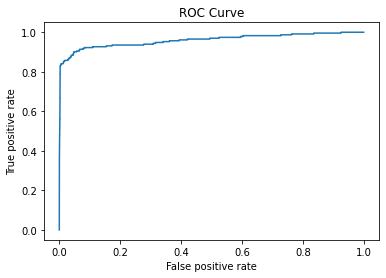

AUC : 0.959680600979423
The best training F1 Score is 0.44599303135888496 with threshold -10
validation F1 Score is  0.4841075794621027  with threshold  -10 


Best Validation F1 Score is 0.7327586206896551 with n_components 1


In [50]:
# cols2 include ['V14','V17'] features
fit_gaussian(6,cols2,1,100,1,'Single Gaussian model fitted on whole training data with selected features[cols2]',train=xtrain)



For number of components =  1


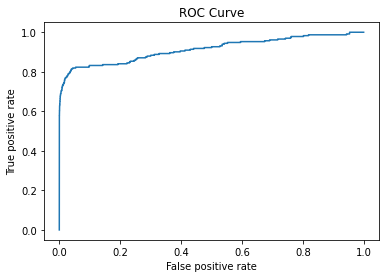

AUC : 0.9139522794875081
The best training F1 Score is 0.6536585365853659 with threshold -11
validation F1 Score is  0.7346938775510204  with threshold  -11 



For number of components =  2


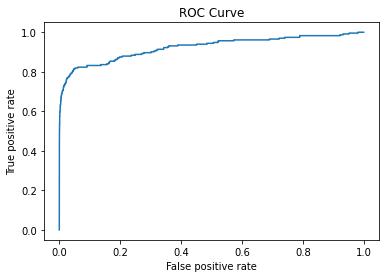

AUC : 0.923448885959541
The best training F1 Score is 0.5409836065573771 with threshold -9
validation F1 Score is  0.5764705882352941  with threshold  -9 



For number of components =  3


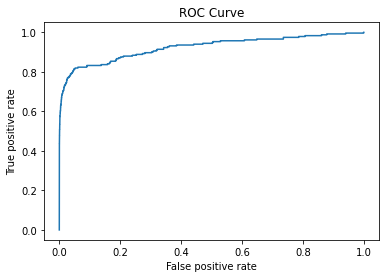

AUC : 0.9234521035121319
The best training F1 Score is 0.5318559556786704 with threshold -9
validation F1 Score is  0.5595238095238095  with threshold  -9 



For number of components =  4


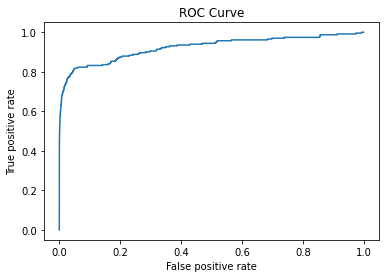

AUC : 0.9232583387825474
The best training F1 Score is 0.5235602094240838 with threshold -8
validation F1 Score is  0.5681818181818181  with threshold  -8 



For number of components =  5


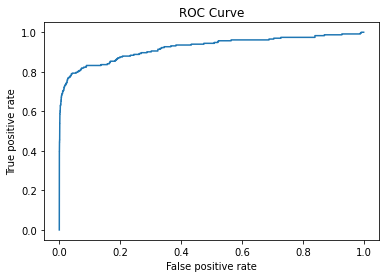

AUC : 0.9225530141290159
The best training F1 Score is 0.4898989898989899 with threshold -8
validation F1 Score is  0.5189189189189188  with threshold  -8 


Best Validation F1 Score is 0.7346938775510204 with n_components 1


In [51]:
# cols1 include ['V12'] features
fit_gaussian(6,cols1,1,100,1,'Single Gaussian model fitted on whole training data with selected features[cols1]',train=xtrain)



For number of components =  1


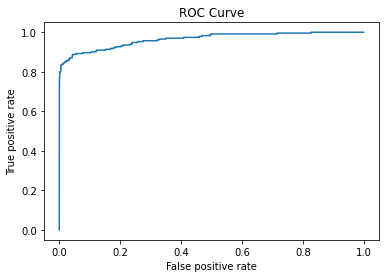

AUC : 0.964933008080017
The best training F1 Score is 0.7472035794183446 with threshold -113
validation F1 Score is  0.8018867924528301  with threshold  -113 



For number of components =  2


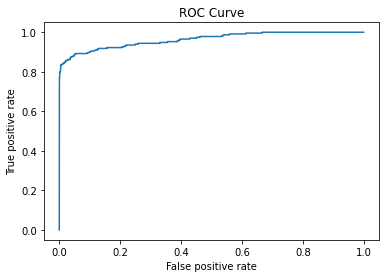

AUC : 0.9630122529352741
The best training F1 Score is 0.738255033557047 with threshold -70
validation F1 Score is  0.7692307692307692  with threshold  -70 



For number of components =  3


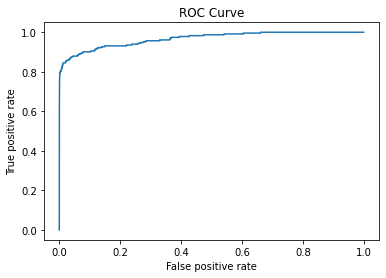

AUC : 0.9668700675537542
The best training F1 Score is 0.7016806722689075 with threshold -29
validation F1 Score is  0.7410714285714286  with threshold  -29 



For number of components =  4


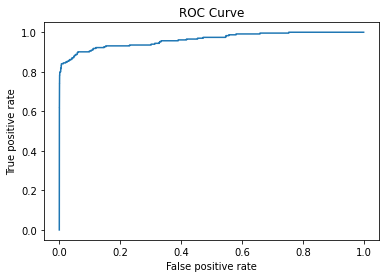

AUC : 0.9622496620332259
The best training F1 Score is 0.7006369426751593 with threshold -29
validation F1 Score is  0.7207207207207207  with threshold  -29 



For number of components =  5


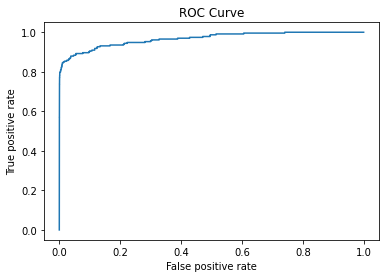

AUC : 0.966917124260396
The best training F1 Score is 0.6991525423728813 with threshold -31
validation F1 Score is  0.730593607305936  with threshold  -31 


Best Validation F1 Score is 0.8018867924528301 with n_components 1


In [52]:
# cols include ['V14','V17','V12','V10','V16','V11','V4'] features
fit_gaussian(6,cols,10,120,1,'Single Gaussian model fitted on non-fraudulent data with selected features[cols]',train=xtrain[ytrain==0])



For number of components =  1


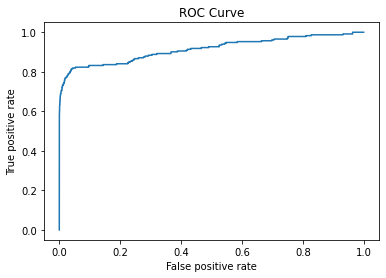

AUC : 0.9145485476710117
The best training F1 Score is 0.6520681265206814 with threshold -12
validation F1 Score is  0.7411167512690356  with threshold  -12 



For number of components =  2


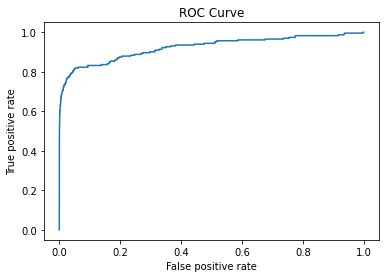

AUC : 0.9236506326945915
The best training F1 Score is 0.547872340425532 with threshold -10
validation F1 Score is  0.5955056179775281  with threshold  -10 



For number of components =  3


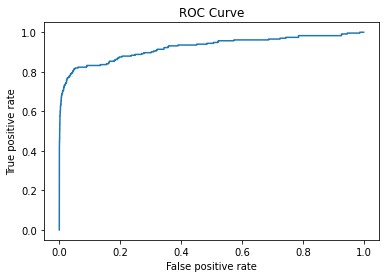

AUC : 0.9231474879081898
The best training F1 Score is 0.5128205128205128 with threshold -13
validation F1 Score is  0.5217391304347826  with threshold  -13 



For number of components =  4


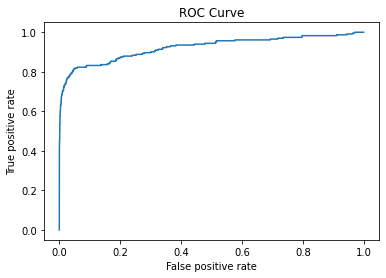

AUC : 0.9230930370181901
The best training F1 Score is 0.5014409221902016 with threshold -13
validation F1 Score is  0.5  with threshold  -13 



For number of components =  5


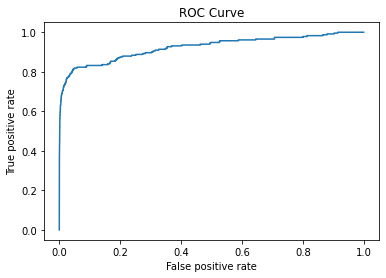

AUC : 0.9241123824293908
The best training F1 Score is 0.46560846560846564 with threshold -14
validation F1 Score is  0.4624277456647399  with threshold  -14 


Best Validation F1 Score is 0.7411167512690356 with n_components 1


In [53]:
# cols1 include ['V12'] feature

fit_gaussian(6,cols1,10,120,1,'Single Gaussian model fitted on non-fraudulent data with selected features[cols1]',train=xtrain[ytrain==0])



For number of components =  1


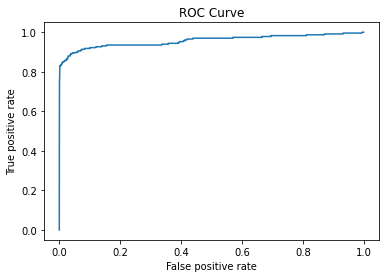

AUC : 0.9569802699675126
The best training F1 Score is 0.6947791164658634 with threshold -36
validation F1 Score is  0.722689075630252  with threshold  -36 



For number of components =  2


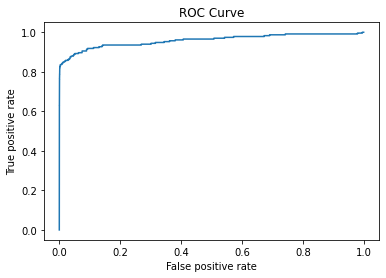

AUC : 0.9588613625889715
The best training F1 Score is 0.708595387840671 with threshold -20
validation F1 Score is  0.7467811158798284  with threshold  -20 



For number of components =  3


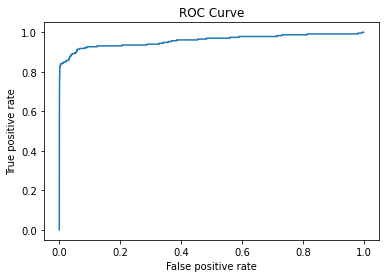

AUC : 0.9582867200714396
The best training F1 Score is 0.694560669456067 with threshold -16
validation F1 Score is  0.7172995780590717  with threshold  -16 



For number of components =  4


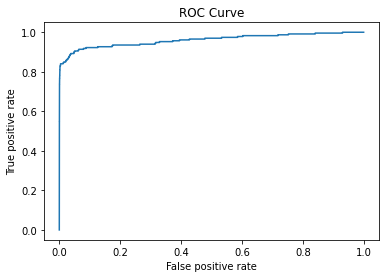

AUC : 0.9604194005551021
The best training F1 Score is 0.6763485477178423 with threshold -13
validation F1 Score is  0.7088607594936708  with threshold  -13 



For number of components =  5


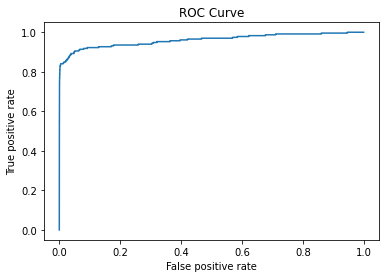

AUC : 0.9605646235537719
The best training F1 Score is 0.6839999999999999 with threshold -12
validation F1 Score is  0.7125506072874495  with threshold  -12 


Best Validation F1 Score is 0.7467811158798284 with n_components 2


In [54]:
# cols2 include ['V14','V17'] features

fit_gaussian(6,cols2,10,120,1,'Single Gaussian model fitted on non-fraudulent data with selected features[cols2]',train=xtrain[ytrain==0])



For number of components =  1


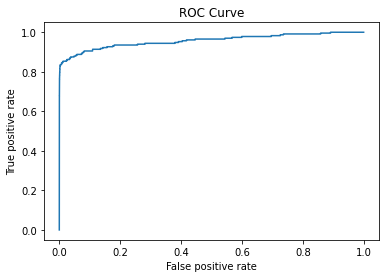

AUC : 0.9571853580071766
The best training F1 Score is 0.7201834862385321 with threshold -61
validation F1 Score is  0.7511737089201878  with threshold  -61 



For number of components =  2


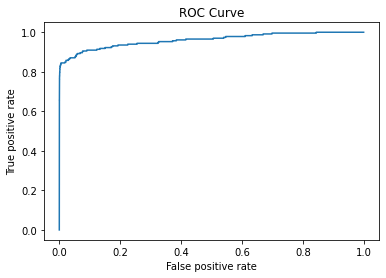

AUC : 0.9606754434901239
The best training F1 Score is 0.7157894736842105 with threshold -23
validation F1 Score is  0.7404255319148936  with threshold  -23 



For number of components =  3


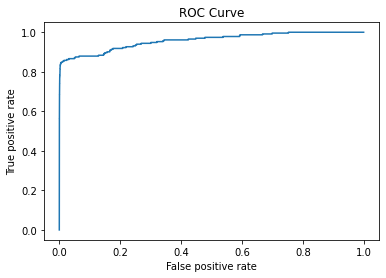

AUC : 0.9581766117092185
The best training F1 Score is 0.6511627906976745 with threshold -25
validation F1 Score is  0.7105263157894739  with threshold  -25 



For number of components =  4


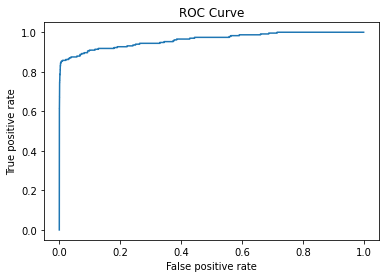

AUC : 0.9614543387211665
The best training F1 Score is 0.6618357487922705 with threshold -16
validation F1 Score is  0.7219512195121951  with threshold  -16 



For number of components =  5


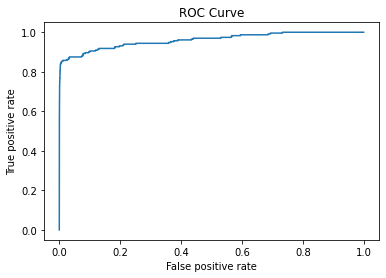

AUC : 0.9604016421398408
The best training F1 Score is 0.6356968215158924 with threshold -15
validation F1 Score is  0.7192118226600984  with threshold  -15 


Best Validation F1 Score is 0.7511737089201878 with n_components 1


In [55]:
# cols3 include ['V12','V14','V17'] features

fit_gaussian(6,cols3,10,120,1,'Single Gaussian model fitted on non-fraudulent data with selected features[cols3]',train=xtrain[ytrain==0])

## Two gaussian models with all features

In [56]:
def compute_c(S1,S2):
    b_f1 = 0
    f1_n = 0
    b_c = 0
    for c in np.arange(0,10,0.1):
      #y_pred = (S1 < c*S2)
      y_pred = np.where(S1 < c*S2,1,0)
      f1_n = f1_score(ytrain,y_pred)
      if f1_n > b_f1:
        b_f1 = f1_n
        b_c = c
    return b_f1,b_c

In [57]:

def fit_twogaussian(components,features,model_name):
  """
  components: Number of components to be tested
  features : Features to be included
  model_name: Name of the model being tested

  """
  max_f1 = []
  best_f1 = []
  best_c = []
  f1_v = []
  ct = []
  for n in range(1,components):
    G1 = GaussianMixture(n_components=1,random_state = 31).fit(xtrain[features][ytrain==0])

    G2 = GaussianMixture(n_components=n,random_state = 31).fit(xtrain[features][ytrain==1])

    S1 = np.array(G1.score_samples(xtrain[features]))
    S2 = np.array(G2.score_samples(xtrain[features]))

    #Training
    b_f1,b_c = compute_c(S1,S2)  
    best_f1.append(b_f1)
    best_c.append(b_c)
    print('for n_components = ',n)
    print('Best Training F1 score: ',max(best_f1),' with C ',round(best_c[best_f1.index(max(best_f1))],2))
    max_f1.append(max(best_f1))
    ct.append(round(best_c[best_f1.index(max(best_f1))],2))
    #validation
    c_v = best_c[best_f1.index(max(best_f1))]
    S1_v = np.array(G1.score_samples(xvalid[features]))
    S2_v = np.array(G2.score_samples(xvalid[features]))
    y_pred = np.where(S1_v < c_v*S2_v,1,0)
    f1_v.append(f1_score(yvalid,y_pred))
    print('validation F1 score: ',f1_v[-1],'with C',c_v,'\n')

  print('\nBest Validation F1 Score is {} with n_components {}'.format(max(f1_v),f1_v.index(max(f1_v))+1))
  model[model_name] = [f1_v.index(max(f1_v))+1,ct[f1_v.index(max(f1_v))],max_f1[f1_v.index(max(f1_v))],max(f1_v)]

In [58]:
fit_twogaussian(15,columns,'Two Gaussian model fitted  with all features')

for n_components =  1
Best Training F1 score:  0.7080745341614907  with C  5.9
validation F1 score:  0.7586206896551726 with C 5.9 

for n_components =  2
Best Training F1 score:  0.7692307692307694  with C  6.6
validation F1 score:  0.8341232227488151 with C 6.6000000000000005 

for n_components =  3
Best Training F1 score:  0.8017429193899782  with C  5.9
validation F1 score:  0.8055555555555555 with C 5.9 

for n_components =  4
Best Training F1 score:  0.8043956043956044  with C  5.9
validation F1 score:  0.8246445497630333 with C 5.9 

for n_components =  5
Best Training F1 score:  0.8043956043956044  with C  5.9
validation F1 score:  0.8246445497630333 with C 5.9 

for n_components =  6
Best Training F1 score:  0.8250539956803457  with C  3.8
validation F1 score:  0.8387096774193548 with C 3.8000000000000003 

for n_components =  7
Best Training F1 score:  0.8250539956803457  with C  3.8
validation F1 score:  0.37524177949709864 with C 3.8000000000000003 

for n_components =  8
B

## Two gaussian model with selected features

In [59]:
# cols1 include ['V12'] feature

fit_twogaussian(11,cols1,'Two Gaussian model fitted  with selected features[cols1]')

for n_components =  1
Best Training F1 score:  0.6600985221674877  with C  4.9
validation F1 score:  0.7422680412371133 with C 4.9 

for n_components =  2
Best Training F1 score:  0.6600985221674877  with C  4.9
validation F1 score:  0.7474747474747475 with C 4.9 

for n_components =  3
Best Training F1 score:  0.6600985221674877  with C  4.9
validation F1 score:  0.7422680412371133 with C 4.9 

for n_components =  4
Best Training F1 score:  0.6600985221674877  with C  4.9
validation F1 score:  0.6948356807511737 with C 4.9 

for n_components =  5
Best Training F1 score:  0.6617283950617284  with C  5.6
validation F1 score:  0.7395833333333333 with C 5.6000000000000005 

for n_components =  6
Best Training F1 score:  0.6617283950617284  with C  5.6
validation F1 score:  0.7096774193548386 with C 5.6000000000000005 

for n_components =  7
Best Training F1 score:  0.6617283950617284  with C  5.6
validation F1 score:  0.7096774193548386 with C 5.6000000000000005 

for n_components =  8
Be

In [60]:
# cols2 include ['V14','V17'] features

fit_twogaussian(11,cols2,'Two Gaussian model fitted with selected features[cols2]')

for n_components =  1
Best Training F1 score:  0.7361111111111112  with C  7.6
validation F1 score:  0.772093023255814 with C 7.6000000000000005 

for n_components =  2
Best Training F1 score:  0.762979683972912  with C  7.1
validation F1 score:  0.7830188679245284 with C 7.1000000000000005 

for n_components =  3
Best Training F1 score:  0.762979683972912  with C  7.1
validation F1 score:  0.8 with C 7.1000000000000005 

for n_components =  4
Best Training F1 score:  0.762979683972912  with C  7.1
validation F1 score:  0.8018867924528301 with C 7.1000000000000005 

for n_components =  5
Best Training F1 score:  0.772093023255814  with C  7.7
validation F1 score:  0.7960199004975125 with C 7.7 

for n_components =  6
Best Training F1 score:  0.7876106194690267  with C  6.6
validation F1 score:  0.8037383177570093 with C 6.6000000000000005 

for n_components =  7
Best Training F1 score:  0.7876106194690267  with C  6.6
validation F1 score:  0.7873303167420814 with C 6.6000000000000005 


In [61]:
# cols3 include ['V12','V14','V17'] features

fit_twogaussian(11,cols3,'Two Gaussian model fitted with selected features[cols3]')

for n_components =  1
Best Training F1 score:  0.779510022271715  with C  6.7
validation F1 score:  0.8037383177570093 with C 6.7 

for n_components =  2
Best Training F1 score:  0.7900677200902934  with C  7.0
validation F1 score:  0.8195121951219514 with C 7.0 

for n_components =  3
Best Training F1 score:  0.7981859410430838  with C  7.0
validation F1 score:  0.8137254901960785 with C 7.0 

for n_components =  4
Best Training F1 score:  0.7981859410430838  with C  7.0
validation F1 score:  0.8137254901960785 with C 7.0 

for n_components =  5
Best Training F1 score:  0.7981859410430838  with C  7.0
validation F1 score:  0.826923076923077 with C 7.0 

for n_components =  6
Best Training F1 score:  0.7981859410430838  with C  7.0
validation F1 score:  0.826923076923077 with C 7.0 

for n_components =  7
Best Training F1 score:  0.7981859410430838  with C  7.0
validation F1 score:  0.826923076923077 with C 7.0 

for n_components =  8
Best Training F1 score:  0.7981859410430838  with C

In [62]:
# cols include ['V14','V17','V12','V10','V16','V11','V4'] features

fit_twogaussian(11,cols,'Two Gaussian model fitted with selected features[cols]')

for n_components =  1
Best Training F1 score:  0.781038374717833  with C  6.8
validation F1 score:  0.8450704225352113 with C 6.800000000000001 

for n_components =  2
Best Training F1 score:  0.7873303167420814  with C  7.4
validation F1 score:  0.8476190476190477 with C 7.4 

for n_components =  3
Best Training F1 score:  0.7881548974943052  with C  7.5
validation F1 score:  0.8421052631578947 with C 7.5 

for n_components =  4
Best Training F1 score:  0.7881548974943052  with C  7.5
validation F1 score:  0.8421052631578947 with C 7.5 

for n_components =  5
Best Training F1 score:  0.8017817371937638  with C  5.8
validation F1 score:  0.8623853211009175 with C 5.800000000000001 

for n_components =  6
Best Training F1 score:  0.8044444444444444  with C  5.8
validation F1 score:  0.8715596330275229 with C 5.800000000000001 

for n_components =  7
Best Training F1 score:  0.8146551724137931  with C  4.1
validation F1 score:  0.8584070796460177 with C 4.1000000000000005 

for n_compone

In [63]:
pd.DataFrame.from_dict(model,columns=['n_components','Threshold','Training F1 score','Validation F1 score'],orient='index')

,n_components,Threshold,Training F1 score,Validation F1 score
Single Gaussian model fitted on only fraudulent class with all features,1,-1.0,0.003319,0.003772
Single Gaussian model fitted on whole training data with all features,6,-95.0,0.307054,0.300885
Single Gaussian model fitted on only non-fraudulent class with all features,3,-105.0,0.468165,0.552846
Single Gaussian model fitted on whole training data with selected features [cols],1,-98.0,0.636591,0.715789
Single Gaussian model fitted on whole training data with selected features[cols3],1,-33.0,0.693387,0.726531
Single Gaussian model fitted on whole training data with selected features[cols2],1,-31.0,0.680942,0.732759
Single Gaussian model fitted on whole training data with selected features[cols1],1,-11.0,0.653659,0.734694
Single Gaussian model fitted on non-fraudulent data with selected features[cols],1,-113.0,0.747204,0.801887
Single Gaussian model fitted on non-fraudulent data with selected features[cols1],1,-12.0,0.652068,0.741117
Single Gaussian model fitted on non-fraudulent data with selected features[cols2],2,-20.0,0.708595,0.746781


For two gaussian models, n_components in the table represents n_components of gaussian model fitted on fraudulent data(G2).

In [64]:
print('Cols represent',cols,'features')
print('Cols1 represent',cols1,'features')
print('Cols2 represent',cols2,'features')
print('Cols3 represent',cols3,'features')

Cols represent ['V14', 'V17', 'V12', 'V10', 'V16', 'V11', 'V4'] features
Cols1 represent ['V12'] features
Cols2 represent ['V14', 'V17'] features
Cols3 represent ['V14', 'V17', 'V12'] features


## ** Evaluating performance on test set**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set. **[1]**


As we could see, Two gaussian model with selected features gave us the best F1 score of 0.87, with n_components = 6 and C = 5.8

In [65]:
from sklearn.metrics import precision_score, recall_score

G1 = GaussianMixture(n_components=1,random_state=31).fit(xtrain[cols][ytrain==0])
G2 = GaussianMixture(n_components=6,random_state=31).fit(xtrain[cols][ytrain==1])

S1 = np.array(G1.score_samples(X_test[cols]))
S2 = np.array(G2.score_samples(X_test[cols]))


c = 5.8

y_pred = np.where(S1 < c*S2,1,0)
f1_n = f1_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
print('Precision: ',precision) 
print('Recall: ',recall)
print('F1 score: ',f1_n)

Precision:  0.8682170542635659
Recall:  0.7619047619047619
F1 score:  0.8115942028985507


*The two gaussian model with best set of features and best parameters gives the F1 score of **0.811**.* 